### Init

In [1]:
import pandas as pd
from utils.document_processing import flatten_column

### Documents

In [2]:
from utils.document_processing import *

In [44]:
import psycopg2
psycopg2_conn = psycopg2.connect(dbname='public_contracts', user='postgres', password='admin', host='localhost', port='5432')

In [4]:
loader = DatabaseContractsLoader(psycopg2_conn)
loader.load_documents()
loader.prepare_documents()
loader.prepare_contracts()
df_contracts = pandas.DataFrame.from_dict(loader._contracts, orient='index')
df_contracts

Running query: select * from document where processed=True
Preparing total 1008 documents
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Progress: 100.0%
Preparing total 159 contracts
Progress: 0.0%
Progress: 10.0%
Progress: 19.0%
Progress: 29.0%
Progress: 38.0%
Progress: 48.0%
Progress: 57.0%
Progress: 67.0%
Progress: 76.0%
Progress: 85.0%
Progress: 95.0%


,docs,text
2,"[{'id': 1, 'text': ' SMLOUVA O PROVÁDĚNÍ...",\n<FILE id=1>\n\n \n\n \n\nSMLOUVA O PROVÁDĚNÍ...
3,"[{'id': 3, 'text': ' SMLOUVA © DÍLO č.j....",\n<FILE id=3>\n\n \n\n \n\nSMLOUVA © DÍLO\nč.j...
6,"[{'id': 26, 'text': ' SMLOUVA O PROVÁDĚN...",\n<FILE id=26>\n\n \n\n \n\nSMLOUVA O PROVÁDĚN...
10,"[{'id': 35, 'text': 'N Á V R H SMLOUVA O DÍ...",\n<FILE id=35>\nN Á V R H\n\nSMLOUVA O DÍLO\...
7,"[{'id': 27, 'text': ' SMLOUVA © DÍLO č.j...",\n<FILE id=27>\n\n \n\n \n\nSMLOUVA © DÍLO\nč....
...,...,...
839,"[{'id': 4117, 'text': 'EVROPSKÁ UNIE 6 9 EVROP...",\n<FILE id=4117>\nEVROPSKÁ UNIE 6 9\nEVROPSKÝ ...
840,"[{'id': 4120, 'text': 'c o X bi EVROPSKÁ UNIE ...",\n<FILE id=4120>\nc o X\nbi EVROPSKÁ UNIE . 20...
841,"[{'id': 4121, 'text': '. a EVROPSKÁ UNIE . G0...",\n<FILE id=4121>\n.\n\na EVROPSKÁ UNIE .\nG0. ...
842,"[{'id': 4124, 'text': 'EVROPSKÁ UNIE p »007-1...",\n<FILE id=4124>\nEVROPSKÁ UNIE p\n\n»007-12\n...


### CPV

In [2]:
from utils.subject_context_preprocessing import *
from utils.database import *

In [45]:
class CPVManager(DBManager):
    
    def __init__(self, connection):
        super().__init__(connection)
        self._load_query = 'select * from contract_cpv'
        self._load_enum_query = 'select * from cpv_code'
        self._cpv_enum = None
        
    def loadCPVEnumFromDB(self, parts=10):
        
        print("Running query: " + self._load_enum_query)
        raw_data = self.runQuery(self._load_enum_query)
        
        cpv_codes = {}
        total_codes = len(raw_data)
        print("Loading total " + str(total_codes) + " codes")
        for i, cpv in enumerate(raw_data):
            if i % (int(total_codes / parts)+1) == 0:
                print("Progress: {}%".format(numpy.ceil(i * 100 / total_codes)))
            cpv_id = cpv[0]
            code = cpv[1]
            name = cpv[2]
            cpv_parent_id = cpv[3]
            embedding = cpv[4]
            cpv_codes[code] = {'id': cpv_id, 'name': name, 'cpv_parent_id': cpv_parent_id, 'embedding': embedding}
        self._cpv_enum = cpv_codes
        return pandas.DataFrame.from_dict(cpv_codes, orient='index')
       
    def loadFromDB(self, parts=10):
        print("Running query: " + self._load_query)
        raw_data = self.runQuery(self._load_query)
        
        contract_cpvs = {}
        total_recors = len(raw_data)
        print("Loading total " + str(total_recors) + " records")
        for i, item in enumerate(raw_data):
            if i % (int(total_recors / parts)+1) == 0:
                print("Progress: {}%".format(numpy.ceil(i * 100 / total_recors)))
            contract_id = item[0]
            cpv_id = item[1]
            contract_cpv = contract_cpvs.get(contract_id, {'cpv_codes':[]})
            contract_cpv['cpv_codes'].append(cpv_id)
            contract_cpvs[contract_id] = contract_cpv
        return pandas.DataFrame.from_dict(contract_cpvs, orient='index')

    
    def _truncateDB(self):
        self.runQuery('truncate table contract_cpv')

    def saveToDB(self, df_contracts):
        self._truncateDB()
        for index, row in df_contracts.iterrows():
            contract_id = index
            print(contract_id)
            cpv_codes = row['cpv_codes']

            for i, cpv_code in enumerate(cpv_codes):
                cpv = self._cpv_enum.get(cpv_code, None)
                if not cpv:
                    continue
                print('    '+cpv_code)
                cpv_id = cpv['id']
                cursor = self._connection.cursor()

                postgres_insert_query = """INSERT INTO contract_cpv (contract_id, cpv_id)
                                            VALUES (%s,%s)"""
                record_to_insert = (contract_id, cpv_id)
                cursor.execute(postgres_insert_query, record_to_insert)

                self._connection.commit()
                count = cursor.rowcount
                cursor.close()
                
cpvmngr = CPVManager(psycopg2_conn)
df_cpv_codes = cpvmngr.loadCPVEnumFromDB()
df_cpv_codes

Running query: select * from cpv_code
Loading total 9455 codes
Progress: 0.0%
Progress: 11.0%
Progress: 21.0%
Progress: 31.0%
Progress: 41.0%
Progress: 51.0%
Progress: 61.0%
Progress: 71.0%
Progress: 81.0%
Progress: 91.0%


,id,name,cpv_parent_id
NaN,0,Common Procurement Vocabulary,NaN
03000000-1,17340,"Produkty zemědělství, hospodářské produkty, pr...",0.0
03100000-2,17341,Produkty zemědělství a zahradnictví,17340.0
03110000-5,17342,Produkty rostlinné výroby v zelinářství a zahr...,17341.0
03111000-2,17343,Semena,17342.0
...,...,...,...
98513300-5,9714,Personál na dobu určitou v domácnostech,9711.0
98513310-8,9715,Pomocnice v domácnosti,9714.0
98514000-9,9716,Služebnictvo,11100.0
98900000-2,9717,Služby poskytované extrateritoriálními organiz...,11026.0


In [46]:
cpvmngr.loadFromDB()

Running query: select * from contract_cpv
Loading total 14 records
Progress: 0.0%
Progress: 15.0%
Progress: 29.0%
Progress: 43.0%
Progress: 58.0%
Progress: 72.0%
Progress: 86.0%


,cpv_codes
10,[12088]
15,[11831]
16,[11831]
17,[11072]
22,"[11831, 12067, 12087, 10608, 13112]"
24,[11831]
59,"[17904, 9543, 17932, 17939]"


In [47]:
extractors = [
    CPVCodeExtractor(keep_text=False)
]
attributes_extractor = SubjectContextPreprocessor(transformers = extractors)

In [48]:
df_contracts['cpv_code'] = df_contracts['text'].apply(lambda text: attributes_extractor.process(text))
df_contracts

,docs,text,cpv_code,cpv_codes
2,"[{'id': 1, 'text': ' SMLOUVA O PROVÁDĚNÍ...",\n<FILE id=1>\n\n \n\n \n\nSMLOUVA O PROVÁDĚNÍ...,,{}
3,"[{'id': 3, 'text': ' SMLOUVA © DÍLO č.j....",\n<FILE id=3>\n\n \n\n \n\nSMLOUVA © DÍLO\nč.j...,,{}
6,"[{'id': 26, 'text': ' SMLOUVA O PROVÁDĚN...",\n<FILE id=26>\n\n \n\n \n\nSMLOUVA O PROVÁDĚN...,,{}
10,"[{'id': 35, 'text': 'N Á V R H SMLOUVA O DÍ...",\n<FILE id=35>\nN Á V R H\n\nSMLOUVA O DÍLO\...,45453100-8,{45453100-8}
7,"[{'id': 27, 'text': ' SMLOUVA © DÍLO č.j...",\n<FILE id=27>\n\n \n\n \n\nSMLOUVA © DÍLO\nč....,,{}
...,...,...,...,...
839,"[{'id': 4117, 'text': 'EVROPSKÁ UNIE 6 9 EVROP...",\n<FILE id=4117>\nEVROPSKÁ UNIE 6 9\nEVROPSKÝ ...,33696500-0\n33696500-0\n33696600-1\n33696500-0,"{33696600-1, 33696500-0}"
840,"[{'id': 4120, 'text': 'c o X bi EVROPSKÁ UNIE ...",\n<FILE id=4120>\nc o X\nbi EVROPSKÁ UNIE . 20...,,{}
841,"[{'id': 4121, 'text': '. a EVROPSKÁ UNIE . G0...",\n<FILE id=4121>\n.\n\na EVROPSKÁ UNIE .\nG0. ...,24312220-2,{24312220-2}
842,"[{'id': 4124, 'text': 'EVROPSKÁ UNIE p »007-1...",\n<FILE id=4124>\nEVROPSKÁ UNIE p\n\n»007-12\n...,,{}


In [49]:
%%time

df_contracts['cpv_codes'] = df_contracts['cpv_code'].apply(lambda text: set(text.split('\n')))
df_contracts

Wall time: 999 µs


,docs,text,cpv_code,cpv_codes
2,"[{'id': 1, 'text': ' SMLOUVA O PROVÁDĚNÍ...",\n<FILE id=1>\n\n \n\n \n\nSMLOUVA O PROVÁDĚNÍ...,,{}
3,"[{'id': 3, 'text': ' SMLOUVA © DÍLO č.j....",\n<FILE id=3>\n\n \n\n \n\nSMLOUVA © DÍLO\nč.j...,,{}
6,"[{'id': 26, 'text': ' SMLOUVA O PROVÁDĚN...",\n<FILE id=26>\n\n \n\n \n\nSMLOUVA O PROVÁDĚN...,,{}
10,"[{'id': 35, 'text': 'N Á V R H SMLOUVA O DÍ...",\n<FILE id=35>\nN Á V R H\n\nSMLOUVA O DÍLO\...,45453100-8,{45453100-8}
7,"[{'id': 27, 'text': ' SMLOUVA © DÍLO č.j...",\n<FILE id=27>\n\n \n\n \n\nSMLOUVA © DÍLO\nč....,,{}
...,...,...,...,...
839,"[{'id': 4117, 'text': 'EVROPSKÁ UNIE 6 9 EVROP...",\n<FILE id=4117>\nEVROPSKÁ UNIE 6 9\nEVROPSKÝ ...,33696500-0\n33696500-0\n33696600-1\n33696500-0,"{33696600-1, 33696500-0}"
840,"[{'id': 4120, 'text': 'c o X bi EVROPSKÁ UNIE ...",\n<FILE id=4120>\nc o X\nbi EVROPSKÁ UNIE . 20...,,{}
841,"[{'id': 4121, 'text': '. a EVROPSKÁ UNIE . G0...",\n<FILE id=4121>\n.\n\na EVROPSKÁ UNIE .\nG0. ...,24312220-2,{24312220-2}
842,"[{'id': 4124, 'text': 'EVROPSKÁ UNIE p »007-1...",\n<FILE id=4124>\nEVROPSKÁ UNIE p\n\n»007-12\n...,,{}


In [50]:
cpvmngr.saveToDB(df_contracts)

2
3
6
10
    45453100-8
7
11
15
    45000000-7
14
16
    45000000-7
17
    98341130-5
22
    45440000-3
    45000000-7
    45331220-4
    45453000-7
    39141000-2
20
24
    45000000-7
59
    48820000-2
    30200000-1
    30232000-4
    30230000-0
48
62
    71520000-9
    71200000-0
    71320000-7
60
63
    48820000-2
    30200000-1
    30232000-4
    30230000-0
    30232100-5
61
    71242000-6
    71327000-6
    71321100-5
    71000000-8
    71251000-2
68
    45000000-7
    45100000-8
    45332200-5
    45252124-3
    45332400-7
    45332300-6
    45111000-8
    45222110-3
    45454100-5
65
72
    45211200-1
    71250000-5
69
70
74
    45112000-5
    45231300-8
    45232421-9
73
103
    51100000-3
542
    45400000-1
488
    30234400-2
    30234300-1
481
    51100000-3
397
    48000000-8
755
71
36
207
64
    72222100-8
    72222300-0
23
    45232400-6
    45233100-0
    45000000-7
29
    45233100-0
    45000000-7
57
26
    45221119-9
    45221100-3
    45221111-3
    45000000-7
12
    

### Analýza

In [36]:
df_cpv = pd.read_csv('../classifier/ecz.edit4.tab', delimiter='\t', names=['ECZ','id','cpvs'], header=0)

In [37]:
df_cpv

,ECZ,id,cpvs
0,00000000,NaN,NaN
1,Z2018-042604,91639B79AE55C530291F3062D3F8C945,30231310-3
2,Z2019-008083,0BD7488AFBFB6AC5FD95FE61C986F6F2,45000000-7
3,Z2019-012043,35358922C7E30362741D675C9B51AAE5,72261000-2
4,Z2019-020706,8E5147A3318F41FF4F001F00104B6E27,45000000-7
...,...,...,...
30505,373567,B10480DF5FFF88BE1F27759400CC1EB1,NaN
30506,373567,6391AAB3FE0D56791C88998BA68EF914,NaN
30507,373567,C4B9DF71617ECAE2A1C1E3EAA689FC56,NaN
30508,Z2019-021486,CF8846EBB3759D95BB3FA5DE409A0725,45000000-7


In [39]:
df_cpv.groupby('ECZ').count()

,id,cpvs
ECZ,,
373567,180,24
376617,148,10
Z2019-009558,2,1
Z2019-010519,1,1
Z2019-013882,2,2
...,...,...
Z2019-12,0,0
Z2019-366656,0,0
Z2019-947567,0,0


In [40]:
df_cpv.nunique()

ECZ     9669
id      9896
cpvs    2201
dtype: int64

In [42]:
df_cpv['cpvs'].value_counts()

45000000-7                                     6832
71250000-5                                      909
71000000-8                                      552
77200000-2                                      474
44212100-0                                      346
                                               ... 
33696000-5                                        1
45254100-3,71351000-3,45214610-9,45221250-9       1
79714000-2                                        1
39715200-9                                        1
39181000-4                                        1
Name: cpvs, Length: 2201, dtype: int64

In [43]:
df_filtered = df_cpv[df_cpv['cpvs'].notnull()].copy()
df_filtered

,ECZ,id,cpvs
1,Z2018-042604,91639B79AE55C530291F3062D3F8C945,30231310-3
2,Z2019-008083,0BD7488AFBFB6AC5FD95FE61C986F6F2,45000000-7
3,Z2019-012043,35358922C7E30362741D675C9B51AAE5,72261000-2
4,Z2019-020706,8E5147A3318F41FF4F001F00104B6E27,45000000-7
5,Z2018-016609,FE82CF9DAAB72F4612415FC744B0C5CD,"45000000-7,45214200-2"
...,...,...,...
30479,373567,5E634EB2D36FB41A2662FC139104F1F0,42410000-3
30480,373567,B681B8B3A5DD780C5EC65D196A83FEEE,42410000-3
30481,373567,AE0125FC089B7592572524D26197B303,42670000-3
30508,Z2019-021486,CF8846EBB3759D95BB3FA5DE409A0725,45000000-7


In [48]:
df_agg = df_filtered.groupby('ECZ')[['cpvs']].apply(
    lambda cpvs: pd.Series(data=[','.join(cpvs['cpvs'])], index=['cpvs'])).reset_index()
df_agg

,ECZ,cpvs
0,373567,"45000000-7,45232400-6,45232420-2,42410000-3,42..."
1,376617,"45000000-7,45232400-6,45232420-2,71250000-5,42..."
2,Z2019-009558,33192230-3
3,Z2019-010519,77211500-7
4,Z2019-013882,"38340000-0,38340000-0"
...,...,...
9131,Z2019-040948,71000000-8
9132,Z2019-041197,71240000-2
9133,Z2019-041354,33141114-2
9134,Z2019-041856,45000000-7


In [49]:
df_unique_cpvs = df_agg.copy()
df_unique_cpvs['cpvs'] = df_unique_cpvs['cpvs'].apply(lambda text: set(text.split(',')))
df_unique_cpvs

,ECZ,cpvs
0,373567,"{42670000-3, 42410000-3, 45000000-7, 45232400-..."
1,376617,"{42670000-3, 45000000-7, 45232400-6, 71250000-..."
2,Z2019-009558,{33192230-3}
3,Z2019-010519,{77211500-7}
4,Z2019-013882,{38340000-0}
...,...,...
9131,Z2019-040948,{71000000-8}
9132,Z2019-041197,{71240000-2}
9133,Z2019-041354,{33141114-2}
9134,Z2019-041856,{45000000-7}


In [61]:
df_unique_cpv = flatten_column(df_unique_cpvs, 'cpvs').copy()
df_flat = df_unique_cpv.rename(columns={'cpvs_flat': 'cpv'})[['ECZ', 'cpv']].copy()
df_flat

,ECZ,cpv
0,373567,42670000-3
0,373567,42410000-3
0,373567,45000000-7
0,373567,45232400-6
0,373567,45232420-2
...,...,...
9131,Z2019-040948,71000000-8
9132,Z2019-041197,71240000-2
9133,Z2019-041354,33141114-2
9134,Z2019-041856,45000000-7


In [62]:
df_flat_filtered = df_flat[df_flat.cpv.str.contains('^[\d]{8}-[\d]$')].copy()
df_flat_filtered

,ECZ,cpv
0,373567,42670000-3
0,373567,42410000-3
0,373567,45000000-7
0,373567,45232400-6
0,373567,45232420-2
...,...,...
9131,Z2019-040948,71000000-8
9132,Z2019-041197,71240000-2
9133,Z2019-041354,33141114-2
9134,Z2019-041856,45000000-7


In [65]:
df_flat_filtered.nunique()

ECZ    9127
cpv    1756
dtype: int64

In [66]:
df_flat_filtered.cpv.value_counts()

45000000-7    703
71250000-5    643
45233000-9    203
71000000-8    152
33100000-1    147
             ... 
32333000-6      1
45212211-8      1
24951311-8      1
77330000-2      1
42100000-0      1
Name: cpv, Length: 1756, dtype: int64

In [67]:
df_flat_filtered['cpv-1'] = df_flat_filtered['cpv'].apply(lambda cpv: cpv[:2])
df_flat_filtered['cpv-2'] = df_flat_filtered['cpv'].apply(lambda cpv: cpv[:3])
df_flat_filtered['cpv-3'] = df_flat_filtered['cpv'].apply(lambda cpv: cpv[:4])
df_flat_filtered['cpv-4'] = df_flat_filtered['cpv'].apply(lambda cpv: cpv[:5])
df_flat_filtered

,ECZ,cpv,cpv-1,cpv-2,cpv-3,cpv-4
0,373567,42670000-3,42,426,4267,42670
0,373567,42410000-3,42,424,4241,42410
0,373567,45000000-7,45,450,4500,45000
0,373567,45232400-6,45,452,4523,45232
0,373567,45232420-2,45,452,4523,45232
...,...,...,...,...,...,...
9131,Z2019-040948,71000000-8,71,710,7100,71000
9132,Z2019-041197,71240000-2,71,712,7124,71240
9133,Z2019-041354,33141114-2,33,331,3314,33141
9134,Z2019-041856,45000000-7,45,450,4500,45000


In [107]:
numpy.sort(df_flat_filtered['cpv-1'].unique())

array(['03', '09', '14', '15', '16', '18', '19', '22', '24', '30', '31',
       '32', '33', '34', '35', '37', '38', '39', '42', '43', '44', '45',
       '48', '50', '51', '55', '60', '63', '64', '65', '66', '70', '71',
       '72', '73', '75', '76', '77', '79', '80', '85', '90', '92', '98'],
      dtype=object)

In [70]:
df_flat_filtered[['ECZ','cpv', 'cpv-1', 'cpv-2', 'cpv-3', 'cpv-4']].nunique()

ECZ      9127
cpv      1756
cpv-1      44
cpv-2     245
cpv-3     636
cpv-4    1134
dtype: int64

In [122]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160

def plot_distribution(s, threshold=10, title='Distribuce CPV oddílů',xlabel='Oddíly', ylabel='Počet výskytů'):
    valcnts = s.value_counts()
    print('#Unique:'+str(len(valcnts)))
    relevant = valcnts[valcnts>threshold]
    print('#Relevant:'+str(len(relevant)))
    display(relevant)
    relevant.plot.bar(figsize=(10,4))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

#Unique:44
#Relevant:19


45    2705
71    1301
33     990
72     604
38     413
30     401
34     395
48     343
90     306
77     305
39     298
79     295
50     275
42     237
09     203
32     183
66     136
85     105
64     103
Name: cpv-1, dtype: int64

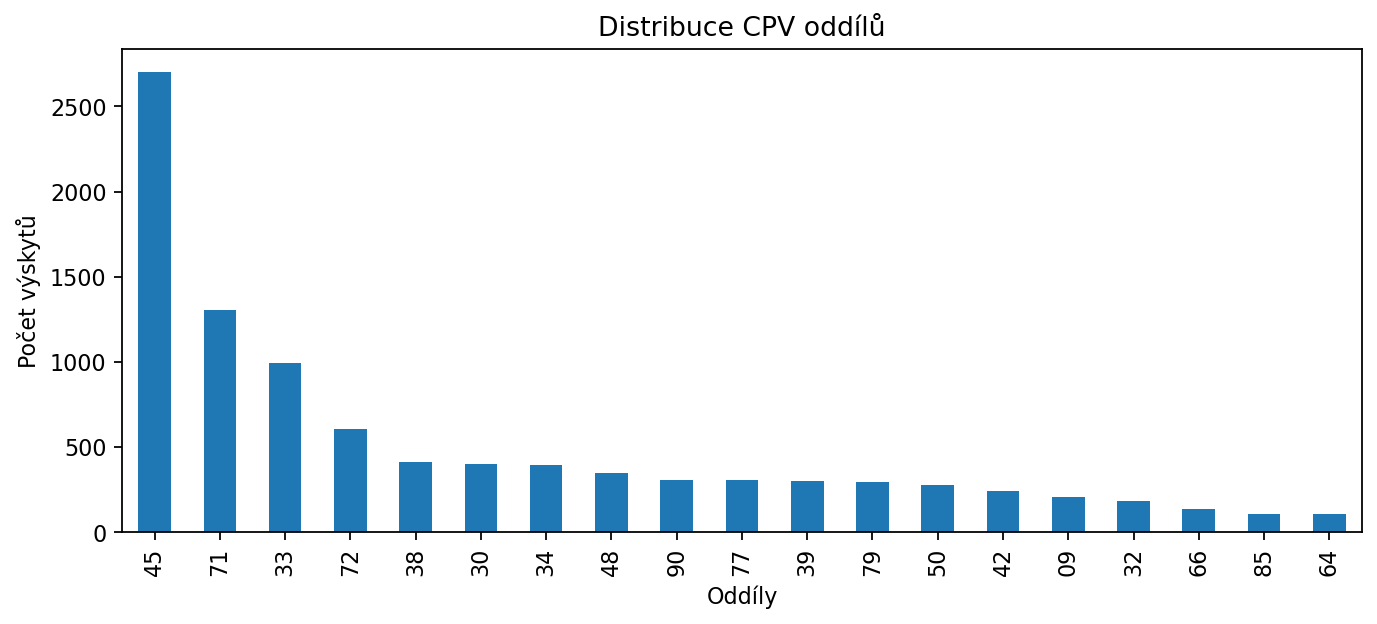

In [123]:
plot_distribution(df_flat_filtered['cpv-1'], 100)

#Unique:245
#Relevant:21


452    1692
712     747
450     703
331     576
722     440
336     379
713     363
302     277
341     256
772     193
488     191
391     171
710     152
380     138
909     126
453     124
384     116
665     109
454     107
905     106
301     105
Name: cpv-2, dtype: int64

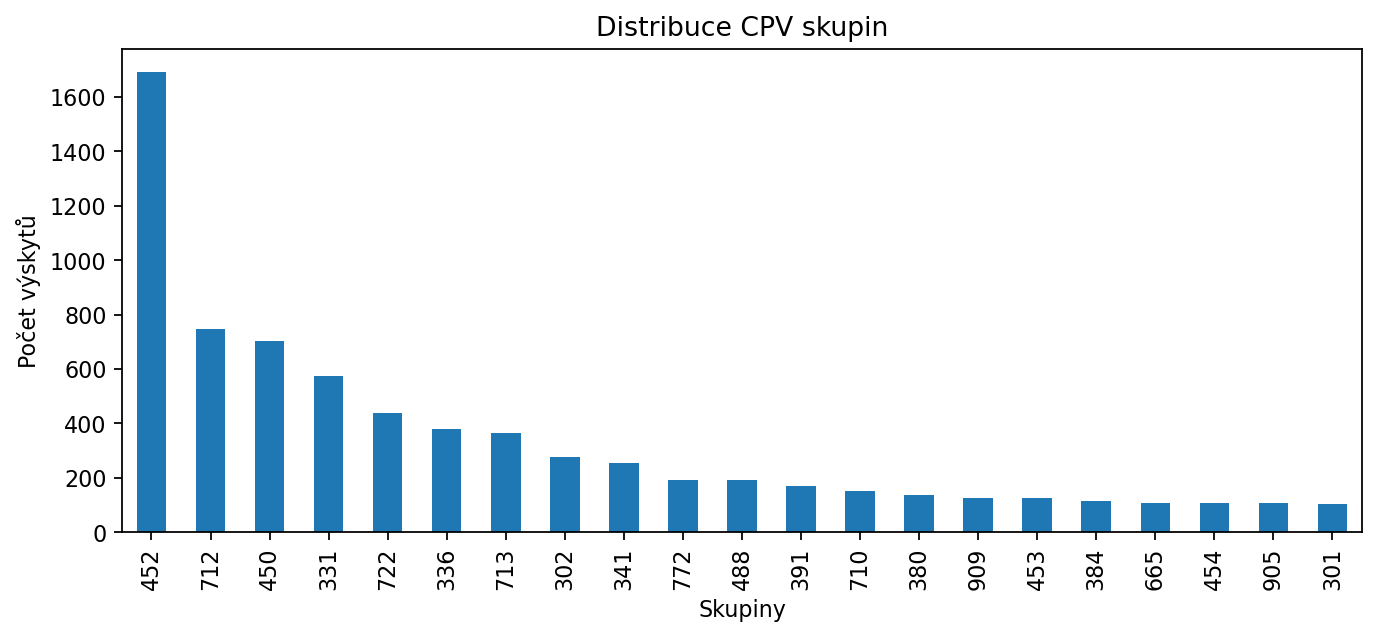

In [124]:
plot_distribution(df_flat_filtered['cpv-2'], 100, 'Distribuce CPV skupin', 'Skupiny')

#Unique:636
#Relevant:17


4523    938
4500    703
7125    658
4521    399
7226    227
3365    185
7132    159
7100    152
4524    150
3310    147
3800    138
9091    118
4522    115
3314    115
6651    109
3021    106
3843    104
Name: cpv-3, dtype: int64

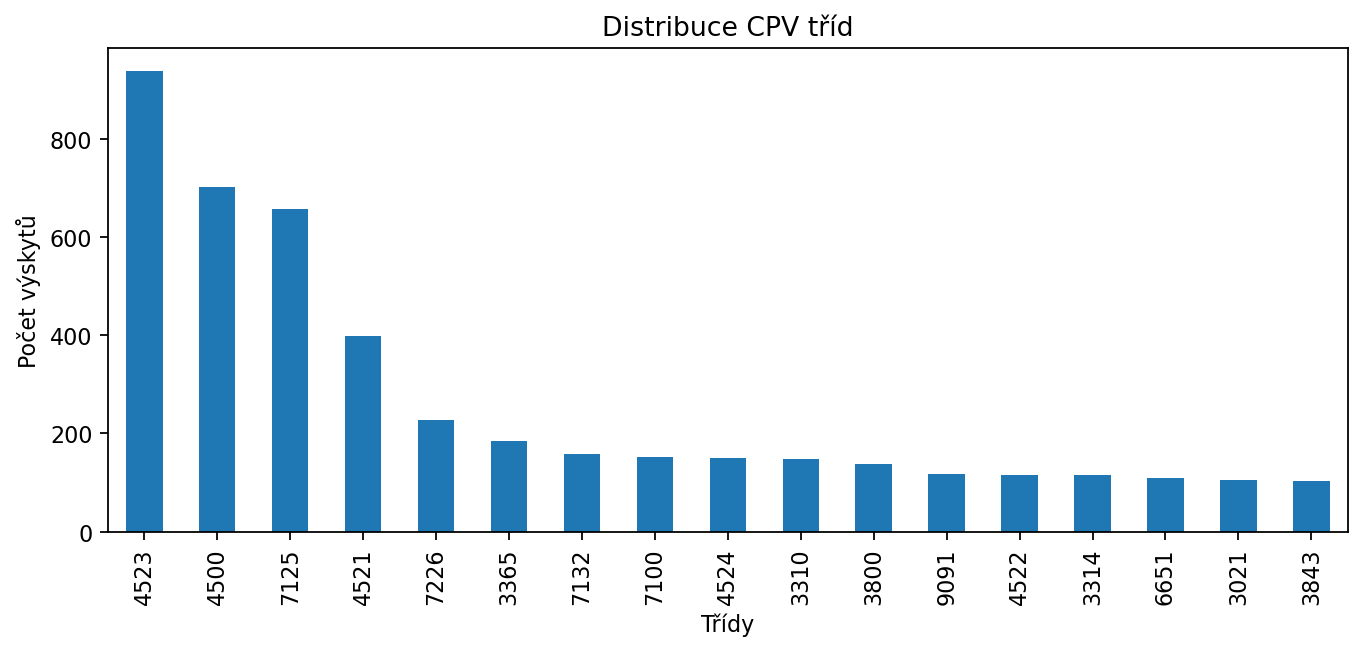

In [125]:
plot_distribution(df_flat_filtered['cpv-3'], 100, 'Distribuce CPV tříd', 'Třídy')

#Unique:1134
#Relevant:9


45233    708
45000    703
71250    643
71000    152
33100    147
33652    143
38000    138
45214    134
45232    102
Name: cpv-4, dtype: int64

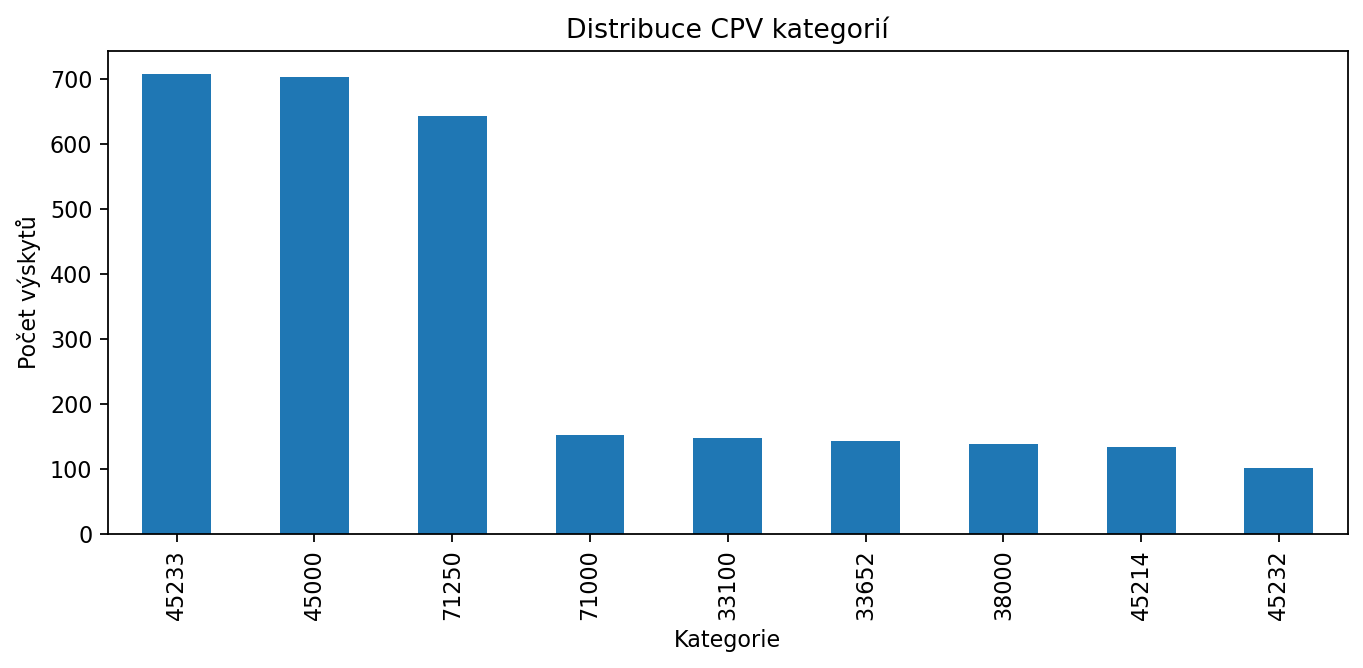

In [126]:
plot_distribution(df_flat_filtered['cpv-4'], 100, 'Distribuce CPV kategorií', 'Kategorie')

#Unique:1503
#Relevant:44


45000000-7    6832
71250000-5     909
71000000-8     552
77200000-2     474
44212100-0     346
34143000-1     327
44113620-7     326
45233000-9     313
45240000-1     252
33182100-0     249
30213000-5     245
33100000-1     241
45233140-2     237
38000000-5     225
45233100-0     220
85300000-2     219
45221100-3     218
09310000-5     217
39000000-2     216
48810000-9     215
60100000-9     206
16700000-2     196
30213300-8     186
09123000-7     185
34927100-2     181
34114110-3     181
72230000-6     177
50100000-6     170
71410000-5     169
34144710-8     166
90700000-4     166
34351100-3     166
34144400-2     164
42630000-1     164
50114100-8     163
90524200-8     163
34928471-0     163
34928110-2     163
71315400-3     154
45214200-2     148
45233142-6     140
45454100-5     130
90910000-9     123
30200000-1     121
Name: cpv_arr_flat, dtype: int64

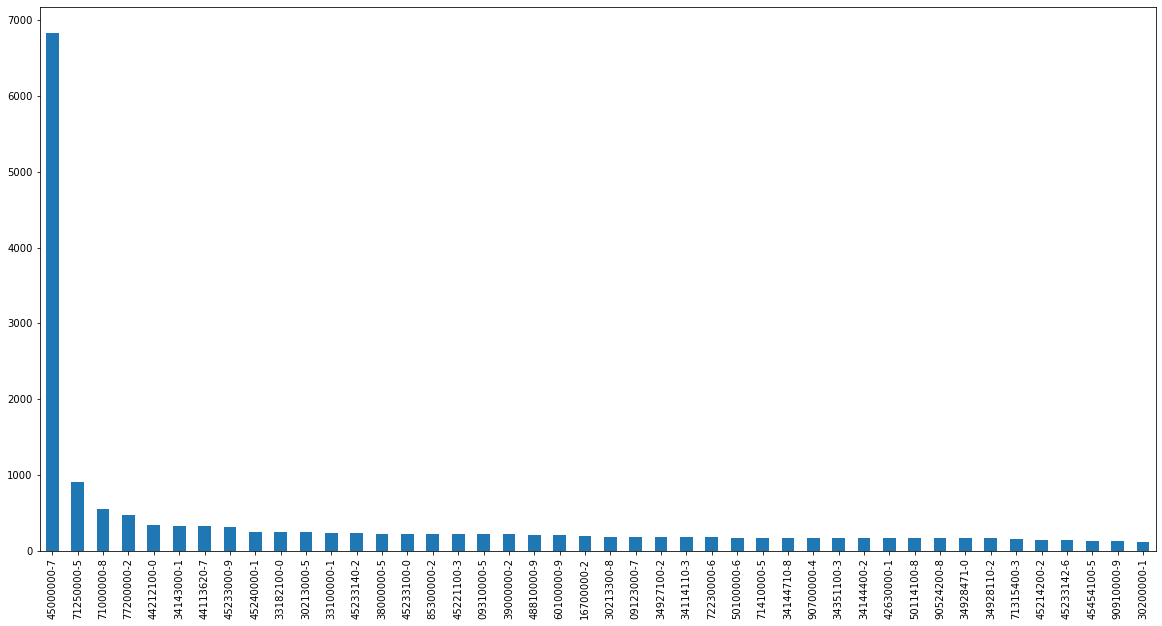

In [93]:
plot_distribution(df_flat_filtered['cpv_arr_flat'], 100)

#Unique:1756
#Relevant:8


45000000-7    703
71250000-5    643
45233000-9    203
71000000-8    152
33100000-1    147
38000000-5    138
45233142-6    132
45233100-0    112
Name: cpv, dtype: int64

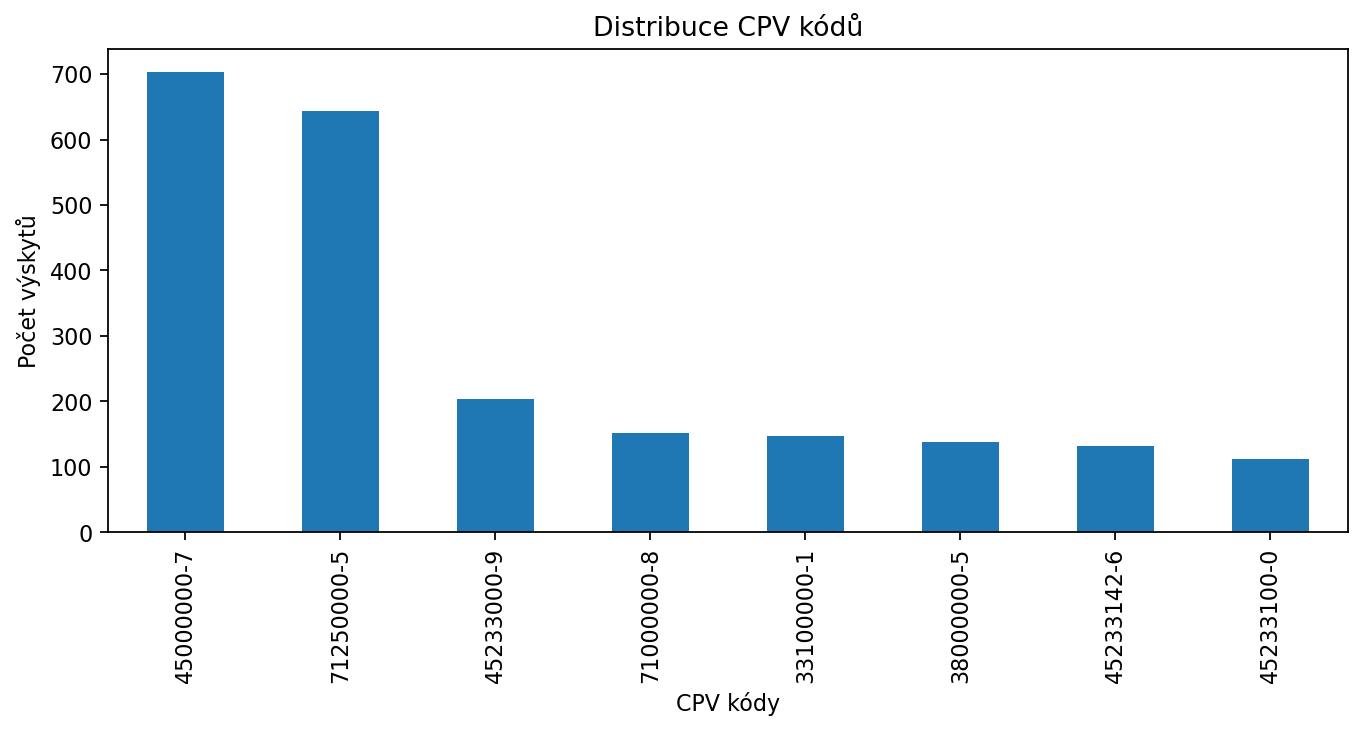

In [127]:
plot_distribution(df_flat_filtered['cpv'], 100, 'Distribuce CPV kódů', 'CPV kódy')

In [115]:
df_cpv_codes = pd.read_csv('../classifier/CPV_codes.txt', delimiter='\t', dtype={'id':'Int64','parent_id': 'Int64'})
df_cpv_codes

,code,name,id,parent_id
0,NaN,Common Procurement Vocabulary,0,<NA>
1,03000000-1,"Produkty zemědělství, hospodářské produkty, pr...",17340,0
2,03100000-2,Produkty zemědělství a zahradnictví,17341,17340
3,03110000-5,Produkty rostlinné výroby v zelinářství a zahr...,17342,17341
4,03111000-2,Semena,17343,17342
...,...,...,...,...
9450,98513300-5,Personál na dobu určitou v domácnostech,9714,9711
9451,98513310-8,Pomocnice v domácnosti,9715,9714
9452,98514000-9,Služebnictvo,9716,11100
9453,98900000-2,Služby poskytované extrateritoriálními organiz...,9717,11026


In [112]:
df_cpv_extension = pd.read_csv('../classifier/CPV_extension.txt', usecols=['code', 'name'], delimiter='\t')
df_cpv_extension

,code,name
0,AA01-1,Kov
1,AA02-4,Hliník
2,AA03-7,Bronz
3,AA04-0,Měď
4,AA05-3,Železo
...,...,...
899,UB04-3,Tiskoviny
900,UB05-6,Kancelářské zboží
901,UB06-9,Zahradnické výrobky
902,UB07-2,Lékařské a zdravotnické produkty


In [116]:
df_cpv_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9455 entries, 0 to 9454
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   code       9454 non-null   object
 1   name       9455 non-null   object
 2   id         9455 non-null   Int64 
 3   parent_id  9454 non-null   Int64 
dtypes: Int64(2), object(2)
memory usage: 314.1+ KB


### Playground

In [9]:
df_cpv = pd.read_csv('../classifier/dummy.tab', delimiter='\t')

In [10]:
df_cpv

,evidencniCisloZakazky,Id VZ v HS,cpv
0,00000000,NaN,NaN
1,Z2018-042604,91639B79AE55C530291F3062D3F8C945,30231310-3
2,Z2019-008083,0BD7488AFBFB6AC5FD95FE61C986F6F2,45000000-7
3,Z2019-012043,35358922C7E30362741D675C9B51AAE5,72261000-2
4,Z2019-020706,8E5147A3318F41FF4F001F00104B6E27,45000000-7
5,Z2018-016609,FE82CF9DAAB72F4612415FC744B0C5CD,"45000000-7,45214200-2"
6,Z2019-018907,B79F7EC83D97129FE20670AFB11D54DC,09123000-7
7,Z2019-001383,FA7EA24947A9FE67B5A51BF2BF8D6A1D,"39100000-3,45351000-2,72261000-2"
8,Z2019-001075,C6C12BE28506A219DC716690B8279861,42620000-8
9,Z2019-004686,C469298AD3769CF8C7F7EFF6513761EE,71315400-3
